In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

sns.set(font_scale=2)

# 1. Вальд v.s. Неймана-Пирсона aka битва за объем тестовой выборки

###### Классический критерий Вальда(just a kind reminder):

$$\mathbb{H}_0 : \theta = \theta_0 ~~~vs.~~~\mathbb{H}_1:\theta \ne \theta_0$$

$$W = \frac{\widehat{\theta} - \theta_0}{\widehat{se}} \rightarrow \mathcal{N}(0, 1), ~~~n \rightarrow \inf$$

###### Критерий Вальда для последовательного анализа:

Статистика выглядит как $Z_n = \log \frac{f_1(x_1, \ldots, x_n)}{f_0(x_1, \ldots, x_n)}$.

Вероятность ошибок 1-го и 2-го рода:

$$
\alpha = P(\text{принять } H_1 |\text{ верна } H_0)
$$$$
\beta = P(\text{принять }H_0 |\text{ верна } H_1)
$$


Последовательный тест отношения правдоподобия (sequential probability  ratio test, SPRT) заключается в вычислении логарифма отношения правдоподобия $Z_n = \log L_n$ (см. выше; в случае независимых наблюдений формулы упрощаются) и сравнении этой величины в каждый момент времени с пороговыми значениями $A < 0, B > 0$, выбранными исходя из заданных вероятностей ошибок 1 и 2 рода. Наблюдения останавливаются в первый момент времени выхода статистики  $Z_n$ за <<коридор>> $(A, B)$: 

$$ \tau_{A,B} = \inf \{n \geqslant 1: Z_n \notin (A, B)\}. $$
    
При этом в каждый момент времени принимается одно из трех решений: 

$$
\begin{cases}
    \text{если } Z_n \leqslant A & \implies \text{верна гипотеза } \mathbb{H}_0, \\
    \text{если } Z_n \geqslant B & \implies \text{верна гипотеза } \mathbb{H}_1, \\
    \text{если } Z_n \in (A, B) & \implies \text{продолжить наблюдения}.
\end{cases}
$$

Обычно полагают 

$$ A = \log \frac{1 - \beta}{\alpha},~B = \log \frac{\beta}{1-\alpha} $$

Исходная постановка:
* Данные i.i.d.;
* $H_0: x_i \sim f_0 = \mathcal{N}(\mu_0, \sigma_0)$
* $H_1: x_i \sim f_1 = \mathcal{N}(\mu_1, \sigma_1)$

В нормальном случае:

$$Z_i = \frac{\mu_1 - \mu_0}{\sigma^2} \left[ X_i - \frac{\mu_1 + \mu_0}{2} \right]$$

<img src="hyp_right.png" alt="hyp_right" width="400"/>
<img src="hyp_wrong.png" alt="hyp_wrong" width="400"/>


###### Критерий Неймана-Пирсона:

$$\mathbb{H}_0 : \theta = \theta_0 ~~~vs.~~~\mathbb{H}_1:\theta = \theta_1$$

$$T = \frac{\mathcal{L}(\theta_0)}{\mathcal{L}(\theta_1)} = \exp \left[ \frac{n}{\sigma^2} (\mu_1 - \mu_0) \left[ \bar{X} - \frac{\mu_1 + \mu_0}{2} \right] \right]$$

$$\bar{X} \geq \mu_0 + z_{(1 - \alpha)} \frac{\sigma}{\sqrt{n}}$$

В данной задаче у нас 


$\mathbb{H}_0$: 

$$\mu_0 = 0,~~\sigma = 1$$

$\mathbb{H}_1$:

$$~~\mu_1 = r = 0.1,~~\sigma = 1$$

In [2]:
# число повторений Монте-Карло
replications = 1000

# объем выборок, для которого будем вычислять 
# ошибки 1 и 2 рода
sample_sizes = np.arange(1, 2000, 5)

In [3]:
# будем проверять 
mu_0 = 0.
mu_1 = 0.1
sigma = 1.

In [4]:
def neyman_pearson_statistic(sample, mu_0=0., mu_1=0.1, sigma=1.):
    """
    Процедура, вычисляющая значение статистики Неймана-Пирсона в случае нормального распределения
    """
    X_n = np.cumsum(sample)
    n_n = np.cumsum(np.arange(1, 1 + len(X_n)))
    return X_n / n_n

def neyman_pearson_decide(criterion_values, z_alpha, mu_0=0., mu_1=0.1, sigma=1.):
    """
    для проверки гипотезы о среднем значении
    нормального распределения такой порог h
    дает равные вероятности ошибки 1 и 2 рода
    """
    critical_value = mu_0 + z_alpha * sigma / np.sqrt(np.cumsum(np.arange(1, 1 + len(criterion_values))))
    for t, value in enumerate(criterion_values):
        if value >= critical_value[t]:
            return t, 1.0    # верна гипотеза H_1
    return t, 0.0      # по умолчанию не отклоняем гипотезу H_0

In [5]:
def wald_sprt_compute(X, mu_0=0., mu_1=0.1, sigma=1.):
    """
    Расчёт S_k написанных выше
    """
    return np.cumsum((mu_1 - mu_0) / sigma**2 * (X - (mu_1 + mu_0) / 2.0))

def wald_sprt_decide(criterion_values, a, b):
    """
    Последовательно проверяем гипотезу пока не выйдет за границы
    """
    for t, value in enumerate(criterion_values):
        if value >= b:
            return t, 1.0    # верна гипотеза H_1
        elif value <= a:
            return t, 0.0    # верна гипотеза H_0
        else:
            continue       # продолжать наблюдения
    return t, 0.0      # по умолчанию не отклоняем гипотезу H_0

Код вычисления статистик, относящихся к вероятностям 1 и 2 рода, для критерия Неймана-Пирсона.

In [6]:
from scipy.stats import norm
alpha = 0.05
beta = 0.1
z_alpha = norm().ppf(1 - alpha)

In [7]:
a = np.log(beta / (1 - alpha))
b = np.log((1 - beta) / alpha)

In [8]:
empirical_alpha = defaultdict(lambda: defaultdict(float))
empirical_beta = defaultdict(lambda: defaultdict(float))

for sample_size in tqdm(sample_sizes):
    for _ in range(replications):
        h_0_sample = np.random.randn(sample_size) + mu_0
        h_1_sample = np.random.randn(sample_size) + mu_1
        
        # wald sprt
        # calc alpha
        s_k = wald_sprt_compute(h_0_sample)
        _, w = wald_sprt_decide(s_k, a, b)
        empirical_alpha[sample_size]["sprt"] += w / replications
        
        # calc beta
        s_k = wald_sprt_compute(h_1_sample)
        _, w = wald_sprt_decide(s_k, a, b)
        empirical_beta[sample_size]["sprt"] += (1 - w) / replications
        
        # Neyman–Pearson
        # calc alpha
        n_k = neyman_pearson_statistic(h_0_sample)
        _, w = neyman_pearson_decide(n_k, z_alpha=z_alpha)
        empirical_alpha[sample_size]["np"] += w / replications

        # calc beta
        s_k = neyman_pearson_statistic(h_1_sample)
        _, w = neyman_pearson_decide(s_k, z_alpha=z_alpha)
        empirical_beta[sample_size]["np"] += (1 - w) / replications

In [9]:
keys = empirical_alpha.keys()
alpha_sprt = [empirical_alpha[key]['sprt'] for key in keys]
alpha_np = [empirical_alpha[key]['np'] for key in keys]

In [10]:
keys = empirical_beta.keys()
beta_sprt = [empirical_beta[key]['sprt'] for key in keys]
beta_np = [empirical_beta[key]['np'] for key in keys]

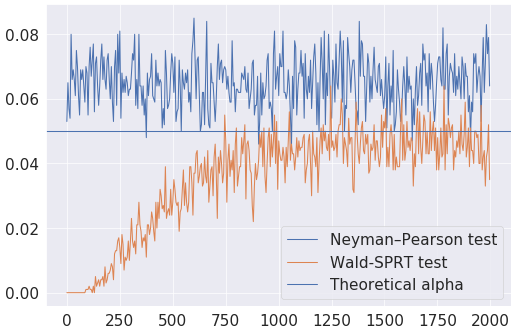

In [18]:
plt.figure(figsize=(12, 8), dpi=50)
plt.plot(sample_sizes, alpha_np, label='Neyman–Pearson test')
plt.plot(sample_sizes, alpha_sprt, label='Wald-SPRT test')
plt.axhline(alpha, label="Theoretical alpha")
plt.legend()
plt.show()

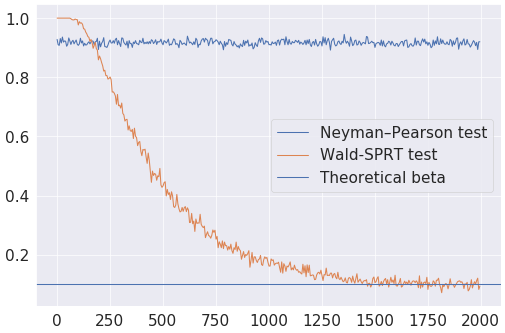

In [19]:
plt.figure(figsize=(12, 8), dpi=50)
plt.plot(sample_sizes, beta_np, label='Neyman–Pearson test')
plt.plot(sample_sizes, beta_sprt, label='Wald-SPRT test')
plt.axhline(beta, label="Theoretical beta")
plt.legend()
plt.show()

### 2. SRPT for Poisson distribution

In [13]:
!pip install sprt

In [14]:
import sprt as spr
test = sprt.SPRTPoisson(alpha=0.05, beta=0.2, h0=1, h1=1.1, values=np.random.poisson(lam=1., size=1000))

Decision:	Accept

      values     lower     upper
n                               
991      998  1023.415  1068.853
992     1002  1024.464  1069.902
993     1004  1025.513  1070.952
994     1006  1026.562  1072.001
995     1007  1027.612  1073.050
996     1010  1028.661  1074.099
997     1010  1029.710  1075.148
998     1011  1030.759  1076.198
999     1011  1031.809  1077.247
1000    1011  1032.858  1078.296


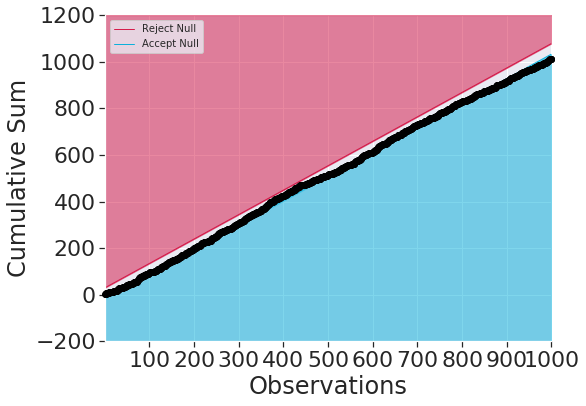

In [15]:
test.plot()

In [16]:
# увеличим количество сэмплов и их variance
test = sprt.SPRTPoisson(alpha=0.05, beta=0.1, h0=1, h1=1.1, values=np.random.poisson(lam=1., size=1000))

Decision:	Accept

      values     lower     upper
n                               
991     1005  1016.142  1070.089
992     1005  1017.192  1071.138
993     1005  1018.241  1072.187
994     1007  1019.290  1073.237
995     1007  1020.339  1074.286
996     1007  1021.388  1075.335
997     1008  1022.438  1076.384
998     1008  1023.487  1077.433
999     1008  1024.536  1078.483
1000    1009  1025.585  1079.532


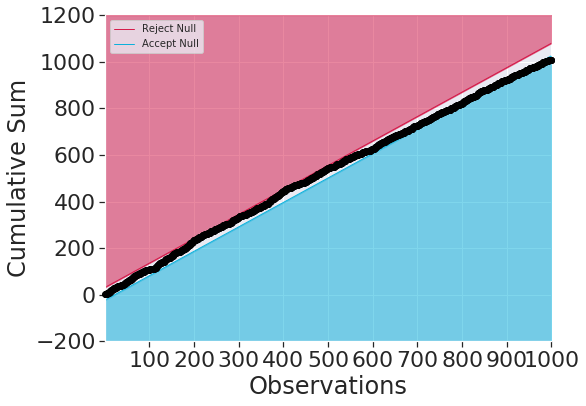

In [17]:
test.plot()